In [1]:
! pwd

/home/guillermo.carrilho/PhysicsSimulationDeepLearning


In [112]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

In [396]:
from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *


geo=UniformGrid(x=500, y=500,bounds=Box(x=5e3, y=5e3))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-':4e3,
          'x+': 4e3,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

dtphi_w_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phi_o=Field( geo,values=tensor(1142.0),
      boundary= {
          'x-': 2e3,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
         'y+': ZERO_GRADIENT
 })#
dtphi_o_1=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': ZERO_GRADIENT,
          'x+': ZERO_GRADIENT,
          'y-': ZERO_GRADIENT,
          'y+': ZERO_GRADIENT
 })

phy=two_phase_flow(
   phi_w,
    phi_o,
    dtphi_w_1,
    dtphi_o_1,
    dt=0.01,
    #w_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v),
    w_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v),
    #o_advection_solver=lambda v: Solve('CG',1e-4,1e-4,x0=v)
    o_advection_solver=lambda v: Solve('CG-adaptive',1e-4,1e-4,x0=v)
)

from Differentiable_simulation import K_o_f_t,K_w_f_t,S_w,dK_o,dK_w,dK_o,dsdpc
#from Differentiable_simulation import *
#dsdpc=(lambda p_c:math.clip((-1*LAMBDA)*((S_w(p_c)-SWR)/PD),lower_limit=1e-6))
import anisotropic_diffusion
print(phy.compute_p_c(phi_w,phi_o))
print(S_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w_f_t(S_w(phy.compute_p_c(phi_w,phi_o))))
print(dsdpc(phy.compute_p_c(phi_w,phi_o)))

print(dK_w(phy.compute_p_c(phi_w,phi_o)))
print(K_w(phy.compute_p_c(phi_w,phi_o)))
print(phy.compute_convective_velocity(phi_o,phi_w,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(phi_w,phi_o)))
print(dK_o(phy.compute_p_c(phi_w,phi_o)))
#print(phy.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(phi_w,phi_o, 1e-4).sample(phi_o.geometry))

PD=2e3
SWR=0.3
SOR=0.1
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.3))
print((lambda s_w:PD*((s_w-SWR)/(1-SWR)))(0.7))

(xˢ=500, yˢ=500) const 1142.0
(xˢ=500, yˢ=500) const 0.8999999761581421
(xˢ=500, yˢ=500) const 0.049999989569187164
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -0.007 ± 0.226 (-7e+00...0e+00)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)


Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

In [395]:
import matplotlib.pyplot as plt

class two_phase_flow(object):
  def __init__(self,phi_w,phi_o,dtphi_w_1,dtphi_o_1,dt,w_advection_solver,o_advection_solver):
    #self.v0=v0
    self.phi_w=phi_w
    self.phi_o=phi_o
    self.dtphi_o_1=dtphi_o_1
    self.dtphi_w_1=dtphi_w_1
    self.dt=dt
    self.p=None
    self.w_advection_solver=w_advection_solver
    self.o_advection_solver=o_advection_solver


  def compute_p_c(self,phi_w,phi_o):
    p_c=phi_o.sample(phi_o.geometry) -\
    phi_w.sample(phi_w.geometry)
    return p_c

  def compute_convective_velocity(self,phi_a,phi_b,dK_a,dK_b):
    p_c=self.compute_p_c(self.phi_w,self.phi_o)
    convective_velocity = grad_phi_dK(phi_a,dK_a(p_c))\
                         - grad_phi_dK(phi_b,dK_b(p_c))

    V=unstack(convective_velocity,"dk")
    convective_velocity=Field(self.phi_o.geometry,values=vec(x=V[0],y=V[1]))
    return convective_velocity

  #def compute_anisotropic_viscosity_effect(self):
    # reformulate differential solver
    
  def phi_w_momentum_eq(self,phi_w,phi_o, dt):
    #grad_phi_w=field.spatial_gradient(self.phi_w,self.phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)
    w_advection_term = dt * advect.semi_lagrangian((phi_w),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_w.geometry)

    w_diffusion_term = dt * anisotropic_diffusion.implicit(phi_w,-1*K_w(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)
    #o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,K_o(p_c), dt=dt,correct_skew=False).sample(phi_w.geometry)

    pressure_chage_term = dt * (self.dtphi_o_1)

    return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_advection_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(pressure_chage_term) + phi_w.with_values(w_diffusion_term)
    #return phi_w + phi_w.with_values(w_diffusion_term)
  
  def phi_o_momentum_eq(self,phi_o,phi_w, dt):
    #grad_phi_w=field.spatial_gradient(phi_w,phi_w.boundary)
    p_c=self.compute_p_c(phi_w,phi_o)

    o_advection_term = dt * advect.semi_lagrangian((phi_o),
                                                    self.compute_convective_velocity(phi_w,phi_o,dK_w,dK_o),
                                                    dt).sample(phi_o.geometry)

    o_diffusion_term = dt * anisotropic_diffusion.implicit(phi_o,-1*K_o(p_c), dt=dt,correct_skew=False).sample(phi_o.geometry)

    pressure_chage_term = dt * (self.dtphi_w_1)

    return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_advection_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(pressure_chage_term) + phi_o.with_values(o_diffusion_term)
    #return phi_o + phi_o.with_values(o_diffusion_term)
  
  def compute_phi_k(self,phi_w,phi_o,phi_w_1,phi_o_1,dt):
    print(((phi_o-phi_o_1)/dt).sample(geo))
    return (phi_w-phi_w_1)/dt,(phi_o-phi_o_1)/dt


  def implicit_time_step(self, phi_w,phi_o, dt):
    new_phi_w = math.solve_linear(self.phi_w_momentum_eq, phi_w, self.w_advection_solver(phi_w),phi_o, dt=-dt)
    print("w phse solved")
    new_phi_o = math.solve_linear(self.phi_o_momentum_eq, phi_o, self.o_advection_solver(phi_o),phi_w, dt=-dt)
    print("o phse solved")
    print(phi_o.sample(geo))
    print(new_phi_o.sample(geo))
    self.dtphi_w_1,self.dtphi_o_1=self.compute_phi_k(new_phi_w,new_phi_o,phi_w,phi_o, dt)
    return new_phi_w,new_phi_o

In [397]:
phi=(phi_w,phi_o)

In [398]:
print(phy.dtphi_o_1.sample(geo))
print(phy.dtphi_w_1.sample(geo))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.dtphi_o_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))
print(phy.dtphi_w_1.sample(geo)/(dsdpc(phy.compute_p_c(*phi))))

(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 9.999999974752427e-07
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 0.0


In [404]:
for i in range(1):
    phi=phy.implicit_time_step(*phi,1e-4)

Diverged: Solve diverged within 891 iterations using Φ-ML CG (PyTorch*)

(xˢ=500, yˢ=500) -5.24e+01 ± 3.3e+05 (-5e+06...5e+06)
(xˢ=500, yˢ=500) const 0.0
(xˢ=500, yˢ=500) const 1142.0


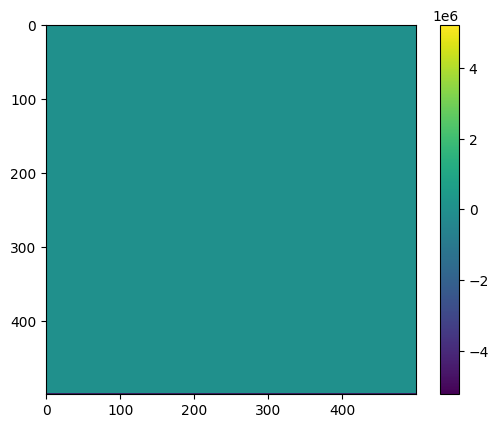

In [400]:
#plt.imshow(phy.dtphi_o_1.sample(geo))
plt.imshow(phy.dtphi_w_1.sample(geo))
plt.colorbar()
print(phy.dtphi_w_1.sample(geo))
print(phy.dtphi_o_1.sample(geo))
print(phy.phi_o.sample(geo))

(xˢ=500, yˢ=500) -5.24e-05 ± 3.3e-01 (-5e+00...5e+00)


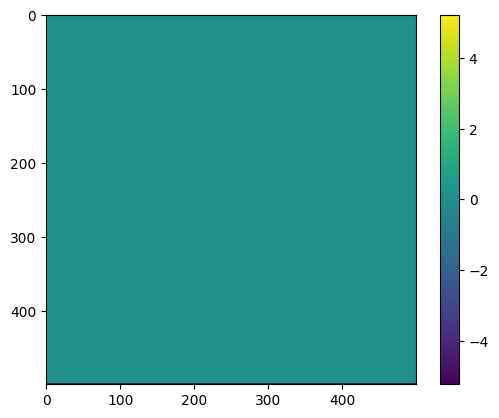

(xˢ=500, yˢ=500) const 1142.0


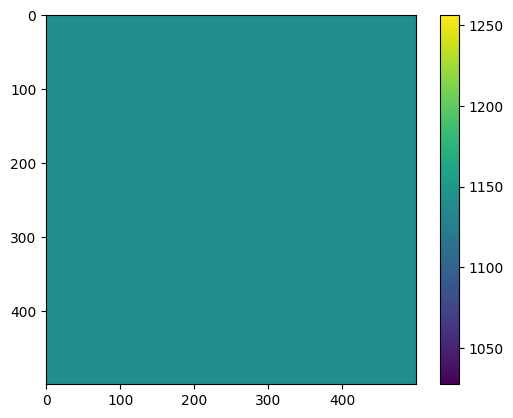

(xˢ=500, yˢ=500) const 0.8999995589256287


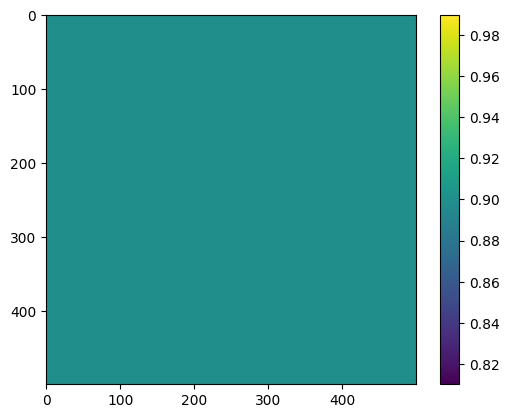

(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)


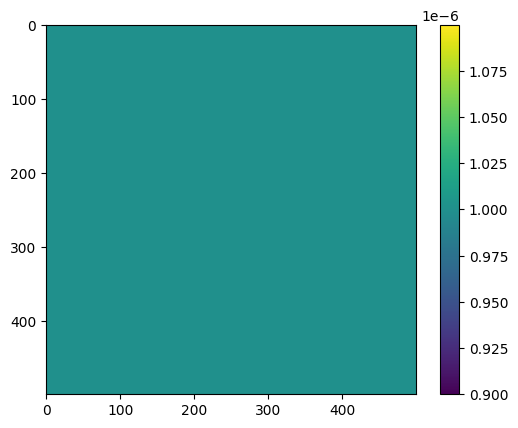

(xˢ=500, yˢ=500) const 1.0000001111620804e-06


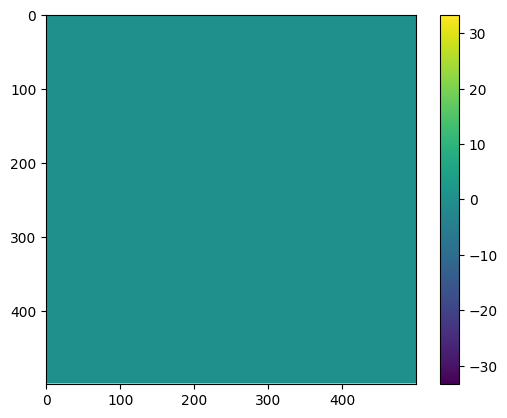

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)


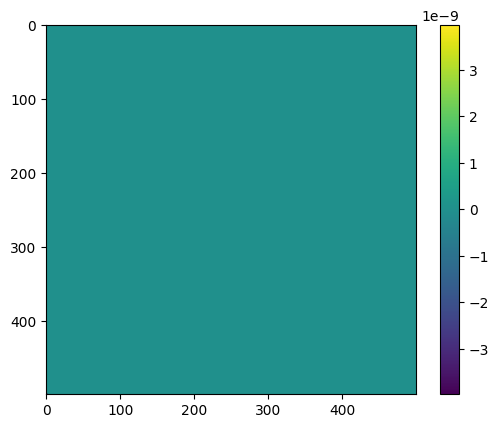

(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(xˢ=500, yˢ=500) const 0.8999995589256287
(xˢ=500, yˢ=500) const 0.05000000074505806
(xˢ=500, yˢ=500) const 1.0000001111620804e-06
(xˢ=500, yˢ=500) 1.14e+03 ± 3.3e-01 (1e+03...1e+03)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 0.083 ± 0.083 (0e+00...2e-01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 2.50e+04 ± 2.5e+04 (0e+00...5e+04)
(xˢ=500, yˢ=500, vectorᶜ=x,y) -8.73e-05 ± 1.5e+00 (-3e+01...3e+01)
(KKᵇ=2, kᵇ=2, xˢ=500, yˢ=500) 3.49e-21 ± 3.5e-21 (0e+00...7e-21)
(dKKᵇ=2, dkᵇ=2, xˢ=500, yˢ=500) 5.47e-19 ± 5.5e-19 (0e+00...1e-18)
(xˢ=500, yˢ=500) -5.23e-05 ± 3.3e-01 (-5e+00...5e+00)


In [403]:
print(phi[0].sample(geo))
plt.imshow(phi[0].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
print(phi[1].sample(geo))
plt.imshow(phi[1].sample(geo).native("x,y"))
plt.colorbar()
plt.show()
plt.imshow(S_w(phy.compute_p_c(*phi)))
plt.colorbar()
print(S_w(phy.compute_p_c(*phi)))
plt.show()
print(phy.compute_p_c(*phi))
plt.imshow(dsdpc(phy.compute_p_c(*phi)))
plt.colorbar()
plt.show()
print(dsdpc(phy.compute_p_c(*phi)))

plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,0])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
plt.imshow(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry).native("x,y")[:,:,1])
plt.colorbar()
plt.show()
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))

print(S_w(phy.compute_p_c(*phi)))
print(K_w_f_t(S_w(phy.compute_p_c(*phi))))
print(dsdpc(phy.compute_p_c(*phi)))
print(phy.compute_p_c(*phi))
print(dK_w(phy.compute_p_c(*phi)))
print(K_w(phy.compute_p_c(*phi)))
print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_w.geometry))
print(K_o(phy.compute_p_c(*phi)))
print(dK_o(phy.compute_p_c(*phi)))
#print(phy.compute_convective_velocity(*phi,dK_w,dK_o).sample(phi_o.geometry))
print(phy.phi_w_momentum_eq(*phi, 1e-5).sample(phi_o.geometry))

In [231]:
print(phy.dtphi_w_1.sample(geo))

(xˢ=240, yˢ=240) -0.005 ± 4.380 (-5e+01...5e+01)


# Gradient Notes

In [ ]:
import torch

### Grandient example

In [ ]:
x1 = torch.ones((3,1,3)).requires_grad_(True)  #
print(x1)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    x1[:,:,1]**2,
    ],axis=2)

#u1 = torch.matmul(M,x1)


#u1=torch.sin(torch.matmul(torch.rand(2,2).requires_grad_(True),x1))
print(u1)
print(u1.shape)
torch.autograd.grad(
    u1,x1,
            grad_outputs=torch.ones_like(u1).to(u1.device),
            create_graph=True,
            retain_graph=True,
            allow_unused=True
            )

tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], requires_grad=True)
tensor([[[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]]], grad_fn=<StackBackward0>)
torch.Size([3, 1, 4])


(tensor([[[0.1585, 2.5403, 0.0000]],
 
         [[0.1585, 2.5403, 0.0000]],
 
         [[0.1585, 2.5403, 0.0000]]], grad_fn=<AddBackward0>),)

### Jacobian computation

Expressed in pytorch with torch.autograd.grad

$$ \textbf{u} \in \mathbb{R}^n \\ \textbf{x},\textbf{e}_i \in \mathbb{R}^m $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i) = \nabla_{\textbf{x}} \textbf{u}_i  $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i) = \nabla_{\textbf{x}} \textbf{u}_i  $$
$$ T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i+\textbf{e}_j) = \nabla_{\textbf{x}} \textbf{u}_i + \nabla_{\textbf{x}} \textbf{u}_j $$
$$ [T_{ag} (\textbf{u},\textbf{x},\textbf{e}_i)]_{i=1}^n = J_{\textbf{x}}(\textbf{u})$$


In [ ]:
unit_vectors=torch.eye(4)
print(u1)
jacobian_rows = [torch.autograd.grad(u1, x1, vec_.unsqueeze(0).unsqueeze(0).tile(u1.shape[0],u1.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
print(jacobian_rows)
print(torch.stack(jacobian_rows,axis=2))
print(torch.stack(jacobian_rows,axis=2).shape)

torch.autograd.grad(u1, x1, unit_vectors[1].unsqueeze(0).unsqueeze(0).tile(u1.shape[0],u1.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0].shape

tensor([[[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]],

        [[1.0000, 1.8415, 0.5403, 1.0000]]], grad_fn=<StackBackward0>)
[tensor([[[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]]], grad_fn=<AddBackward0>), tensor([[[0.5000, 0.5403, 0.0000]],

        [[0.5000, 0.5403, 0.0000]],

        [[0.5000, 0.5403, 0.0000]]], grad_fn=<AddBackward0>), tensor([[[-0.8415,  0.0000,  0.0000]],

        [[-0.8415,  0.0000,  0.0000]],

        [[-0.8415,  0.0000,  0.0000]]], grad_fn=<AddBackward0>), tensor([[[0., 2., 0.]],

        [[0., 2., 0.]],

        [[0., 2., 0.]]], grad_fn=<AddBackward0>)]
tensor([[[[ 0.5000,  0.0000,  0.0000],
          [ 0.5000,  0.5403,  0.0000],
          [-0.8415,  0.0000,  0.0000],
          [ 0.0000,  2.0000,  0.0000]]],


        [[[ 0.5000,  0.0000,  0.0000],
          [ 0.5000,  0.5403,  0.0000],
          [-0.8415,  0.0000,  0.0000],
          [ 0.0000,  2.0000,  0.0000]]],


 

torch.Size([3, 1, 3])

In [ ]:
#

def vector_jacobian(u,x):
    unit_vectors=torch.eye(u.shape[-1])
    jacobian_rows = [torch.autograd.grad(u, x, vec_.unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
    return torch.stack(jacobian_rows,axis=2)


def vector_grad(u,x):
    unit_vectors=torch.eye(u.shape[-1])
    jacobian_rows = [torch.autograd.grad(u, x, vec_.unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
                     for vec_ in unit_vectors]
    return torch.diagonal(torch.stack(jacobian_rows,axis=2),dim1=-2,dim2=-1)

def x_grad(u,x,i,n):
    """
    gradient of degree wrt x for componen i for u
    input:
    u and x are tensors with vectors object at dimension -1
    [b, n_vectors, vector_dimension]

    output:
    [b, n_vectors, input_vector_dimension]
    """
    I=torch.eye(u.shape[-1])

    u=torch.autograd.grad(u ,x,
            I[i].unsqueeze(0).unsqueeze(0).tile(u.shape[0],u.shape[1],1).to(u.device),
            create_graph=True,
            retain_graph=True,
            allow_unused=True)[0]
    if n > 1:
        for i in range(n-1):
            u=vector_grad(u,x)
    return u

In [ ]:
print(x_grad(u1,x1,0,1))
udx=x_grad(u1,x1,0,1)


tensor([[[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000]]], grad_fn=<AddBackward0>)


In [ ]:
print(x1.shape)
x1

torch.Size([3, 1, 3])


tensor([[[1., 1., 1.]],

        [[1., 1., 1.]],

        [[1., 1., 1.]]], requires_grad=True)

In [ ]:
torch.sum(x1*udx,axis=-1)

tensor([[0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SumBackward1>)

In [ ]:
udx[:,:,:2]

tensor([[[0.5000, 0.0000]],

        [[0.5000, 0.0000]],

        [[0.5000, 0.0000]]], grad_fn=<SliceBackward0>)

# Residuals debug

## NS reesidual

In [ ]:
def incompresibble_fluid_loss(up,xt,mu=1,rho=1):
    l=0
    # x-velocity components
    l+=x_grad(up,xt,0,1)[...,2] # dudt
    l+=torch.sum(up[...,:1]*x_grad(up,xt,0,1)[...,:2],axis=-1) # u * grad u
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,0]) #  dpdx
    l-=(mu/rho)*torch.sum(x_grad(up,xt,0,2)[...,:2],axis=-1) # grad**2 u
    # y-velocity components
    l+=x_grad(up,xt,1,1)[...,2] # dvdt
    l+=torch.sum(up[...,1:2]*x_grad(up,xt,0,1)[...,:2],axis=-1) # v * grad v
    l+=(mu/rho)*(x_grad(up,xt,2,1)[...,1]) #  dpdy
    l-=(mu/rho)*torch.sum(x_grad(up,xt,1,2)[...,:2],axis=-1) # grad**2 v
    return l

### Debug

In [ ]:
x1 = torch.randn((3,1,3)).requires_grad_(True)  #
print(x1)
print(x1.shape)

u1 = torch.stack([
    x1[:,:,0]**0.5,
    torch.sin(x1[:,:,1])+x1[:,:,0]**0.5,
    torch.cos(x1[:,:,0]),
    ],axis=2)

print(u1.shape)

tensor([[[-1.5316, -0.0218,  1.3527]],

        [[ 2.0246,  0.5625, -0.8633]],

        [[ 0.5488, -0.9313,  0.3730]]], requires_grad=True)
torch.Size([3, 1, 3])
torch.Size([3, 1, 3])


In [ ]:
incompresibble_fluid_loss(u1,x1,1,1)-0
#x_grad(u1,x1,0,1)[...,0]
#print(x1[:,:,:1])
#print(x_grad(u1,x1,0,1)[...,:2])
#x_grad(u1,x1,0,1)[...,2]
#x_grad(u1,x1,0,2)[...,:2]

tensor([[   nan],
        [0.9955],
        [0.3642]], grad_fn=<SubBackward0>)